# Decoding the IR signal

## How to go about thinking about the problem

This notebook shows my thought process when decoding the IR signal from my air conditioner remote control. This part requires getting the raw output sequence (pulses and spaces) from the remote when clicking buttons (Check the previous chapter).

This code will be using the ir module provided in the git repository. Each function and short and modular, and might help you in decoding your own data.

It is also important that this does not cover all aspects and possibilies of remote IR encodings, just a very specific one, and how I went about it.

In [1]:
from ir.read import *
from ir.plot import *

Before diving in to the steps, it's important to use some common sense. My remote has an LCD which shows it's current state, and I know that if the AC does not have a line of sight and I make multiple changes, the AC will acknowledge them all together when it does. This means that each key press will result in all of the state being sent each time, unlike a TV remote which usually only sends the current press (such as volume up, etc...)

Let's click some buttons and see how the data looks like:

In [2]:
filename = 'clicks.txt'

In [3]:
with open(filename) as f:
    print(f.readlines()[:5])

['pulse 3039\n', 'space 3017\n', 'pulse 998\n', 'space 972\n', 'pulse 971\n']


We can see that each line in the text file is a pulse or space for an X amount of time in microseconds (uS). Let's read those sequences into python. Each sequence ends with a timeout.

In [4]:
with open(filename) as f:
    seqs = parse_input(f.readlines())

In [5]:
print(len(seqs), seqs[0][:10])

7 [(1, 3039), (0, 3017), (1, 998), (0, 972), (1, 971), (0, 974), (1, 970), (0, 1912), (1, 1976), (0, 1943)]


We can see this file has 7 sequences in it, and we've converted them to use 0 (space) and 1 (pulse) with their timings. Lets plot them:

In [6]:
%matplotlib inline

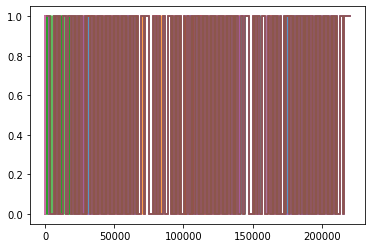

In [7]:
plot(seqs)

We can already see some intresting patterns by overlaying all the sequences on top of each other. There seems to be some sort of a preamble split in the signal that happens twice, but there also seems to be some thing weird in the start of the signal. Let's look at the length of the sequences:

In [8]:
print([len(x) for x in seqs])

[187, 137, 23, 187, 181, 187, 1]


Hmm.... it seems like some of the sequences are about the same length, while others are shorter. IR signals can be effected by many light sources in the room, so let's cut off the short ones and plot again:

In [9]:
seqs = [x for x in seqs if len(x) > 100]

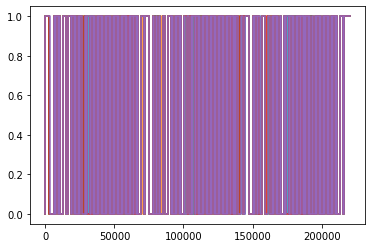

In [10]:
plot(seqs)

We can already see some patterns here. It seems there is a 3 part repetition and also we can see that most changes happen on almost 1000 uS intervals:

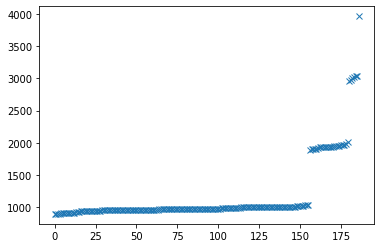

In [11]:
plt.plot(sorted([x[1] for x in seqs[0]]), 'x')

So let's round the data to 1000 uS intervals:

In [12]:
seqs = [round_values(x, 1000) for x in seqs]

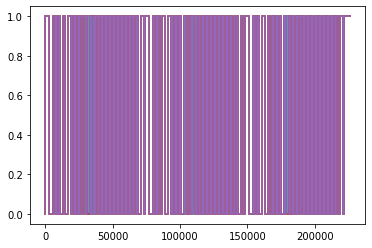

In [13]:
plot(seqs)

From the 2 previous graphs, we can also see that the splits between the repetition have a pulse of 3000 uS and an space of 3000 uS and the sequence ends with a 4000 uS pulse. I guess that the repetition is part of the signal error detection scheme.

Let's validate that the 3 parts are exactly the same, and look at one of them:

In [14]:
seqs_data = [get_data_from_sequence(x) for x in seqs]

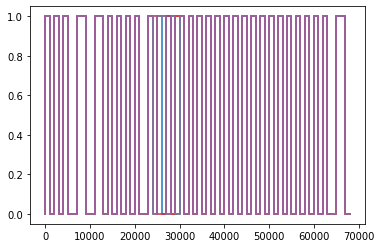

In [15]:
plot(seqs_data)

We can see that the clicks cause small changes in the data, let's try to see if there is any meaning to decoding the data as bits where the clock speed is 1000 uS.

In [16]:
seqs_data = [convert_to_bits(x, 1000) for x in seqs_data]

In [17]:
seqs_data_str = [as_string(x) for x in seqs_data]

import pprint; pprint.pprint(seqs_data_str)

['10101001100110101010100101011010101010101010101010101010101010100110',
 '10101001100110101010100101100110101010101010101010101010101010100110',
 '10101001100110101010100101101010101010101010101010101010101010100110',
 '10101001100110101010100110010110101010101010101010101010101010100110',
 '10101001100110101010100101101010101010101010101010101010101010100110']


The clicks that are sampled here are of changes only to the temprature. Since my remote can go from 16 to 30 degrees, I expect to see some kind of unsigned integer that goes up and down encoded by 5 bits:

In [18]:
import math

math.ceil(math.log(30)/math.log(2))

5

We can see that the changes are in only a specific region of the sequence:

In [19]:
temprature_changes = find_changes_region(seqs_data_str)

temprature_changes

(24, 30, ['010110', '011001', '011010', '100101', '011010'])

Hmm, this seems bigger than 5 bits (6 bits), even when we didn't go the whole range, and they don't go linearly and out of bounds:

In [20]:
[int(x, 2) for x in temprature_changes[2]]

[22, 25, 26, 37, 26]

Here, looking long enough at the bits, and trying going all the range from 16 to 30, got me to see that if we skip the odd bits, the data makes more sense:

In [21]:
[int(x[1::2], 2) for x in temprature_changes[2]]

[6, 5, 4, 3, 4]

Since I knew that when recording the changes were of going between 29, 28, 27, 26, 27, This values had to be related to the changes (sans a few error samples maybe). Let's try widening the length of the number by one bit to the left (this is a game of trail and error, or you could just sample the whole range and then run the above code again). Also remember than one bit = 2 bits, because we skip the odd ones:

In [22]:
[int(x[temprature_changes[0]-2:temprature_changes[1]][1::2], 2) for x in seqs_data_str]

[14, 13, 12, 11, 12]

This seems promising as I know the changes are between 29 to 26, we can see that there is an offset of 15 here, and the temprature is encoded as 4 bit unsigned integer between 1 to 15.

I had no clue about why I needed to discard the odd bits and I had a hunch it is related to some error correction method, but it didn't hit me till a friend pointed me to look at [manchester coding](https://en.wikipedia.org/wiki/Manchester_code) which is commonly used in consumer IR remotes:

In [23]:
seqs_data_str_fixed = [as_string(decode_manchester(x)) for x in seqs_data]

import pprint; pprint.pprint(seqs_data_str_fixed)

['0001010000011100000000000000000010',
 '0001010000011010000000000000000010',
 '0001010000011000000000000000000010',
 '0001010000010110000000000000000010',
 '0001010000011000000000000000000010']


In [24]:
temprature_changes = find_changes_region(seqs_data_str_fixed)

temprature_changes

(12, 15, ['110', '101', '100', '011', '100'])

In [25]:
[int(x, 2) for x in temprature_changes[2]]

[6, 5, 4, 3, 4]

Viola, I was able now to decode the full signal, and mess with the remote keys and record and see which bits were responsible for which AC state:

In [26]:
with open(filename) as f:
    seqs = parse_input(f.readlines())

states = []
for seq in seqs:
    try:
        state = get_state(round_values(seq, 1000))
    except WrongDataError:
        pass # We want to ignore bad signals
    states.append(state)

states

['0001010000011100000000000000000010',
 '0001010000011010000000000000000010',
 '0001010000011010000000000000000010',
 '0001010000011000000000000000000010',
 '0001010000010110000000000000000010',
 '0001010000011000000000000000000010',
 '0001010000011000000000000000000010']

In [27]:
[decode(x) for x in states]

[{'mode': <Modes.cool: 0>,
  'temp': 29,
  'speed': <FanSpeed.medium: 1>,
  'power_cycle': False},
 {'mode': <Modes.cool: 0>,
  'temp': 28,
  'speed': <FanSpeed.medium: 1>,
  'power_cycle': False},
 {'mode': <Modes.cool: 0>,
  'temp': 28,
  'speed': <FanSpeed.medium: 1>,
  'power_cycle': False},
 {'mode': <Modes.cool: 0>,
  'temp': 27,
  'speed': <FanSpeed.medium: 1>,
  'power_cycle': False},
 {'mode': <Modes.cool: 0>,
  'temp': 26,
  'speed': <FanSpeed.medium: 1>,
  'power_cycle': False},
 {'mode': <Modes.cool: 0>,
  'temp': 27,
  'speed': <FanSpeed.medium: 1>,
  'power_cycle': False},
 {'mode': <Modes.cool: 0>,
  'temp': 27,
  'speed': <FanSpeed.medium: 1>,
  'power_cycle': False}]

This is not the comprehensive list of options that is encoded in each state, but it's good enough for my needs, which is to make a web server that will allow me to control the AC parameters I want from any browser.

## Helper script for figuring out which bits are responsible for a specific state

Just change one state to it's full range, and get the bits which are responsible for it:

In [28]:
filename = 'clicks.txt'

with open(filename) as f:
    lines = f.readlines()

bits = find_changes_region([get_state(round_values(seq, 1000)) for seq in parse_input(lines) if len(seq) > 100])

(bits[0], bits[1], [int(x, 2) for x in bits[2]])

(12, 15, [6, 5, 4, 3, 4])